In [1]:
from platform import python_version
print(python_version())

3.7.5


In [3]:
from __future__ import print_function

import math
from functools import partial

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.python.data import Dataset

tf.get_logger().setLevel('ERROR')
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

pandas 로 csv 파일을 읽자.

In [4]:
dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [5]:
dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
dataframe["median_house_value"] /= 1000.0
dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12027,-121.4,39.0,16.0,1698.0,300.0,731.0,291.0,3.1,87.2
1104,-117.1,32.7,52.0,204.0,74.0,248.0,57.0,1.8,47.5
4552,-118.0,33.9,33.0,1999.0,470.0,2170.0,466.0,3.2,154.7
15994,-122.4,37.8,52.0,3017.0,851.0,1588.0,800.0,3.4,471.4
12470,-121.6,39.1,21.0,1432.0,328.0,933.0,336.0,1.7,83.8
...,...,...,...,...,...,...,...,...,...
2495,-117.6,33.4,27.0,1835.0,413.0,1221.0,377.0,3.2,247.1
13249,-121.9,37.4,19.0,1684.0,387.0,1224.0,376.0,4.1,174.1
12870,-121.8,37.2,25.0,4021.0,634.0,2178.0,650.0,5.2,241.2
13296,-121.9,37.7,13.0,3742.0,555.0,1590.0,559.0,7.3,285.4


data_frame 의 describe 함수를 사용하여 data_frame 의 통계 요약 정보를 살펴본다.

In [6]:
dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [8]:
series_feature = dataframe["total_rooms"]
print(type(series_feature), series_feature)
my_feature = dataframe[["total_rooms"]]
print(type(my_feature), my_feature)
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
print(feature_columns)

<class 'pandas.core.series.Series'> 12027   1698.0
1104     204.0
4552    1999.0
15994   3017.0
12470   1432.0
         ...  
2495    1835.0
13249   1684.0
12870   4021.0
13296   3742.0
12531   4780.0
Name: total_rooms, Length: 17000, dtype: float64
<class 'pandas.core.frame.DataFrame'>        total_rooms
12027       1698.0
1104         204.0
4552        1999.0
15994       3017.0
12470       1432.0
...            ...
2495        1835.0
13249       1684.0
12870       4021.0
13296       3742.0
12531       4780.0

[17000 rows x 1 columns]
[NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


series 는 데이터의 벡터의 목록이고 data_frame 은 행렬이다. data_frame 에 series 가 포함되어 있다.

In [9]:
targets = dataframe["median_house_value"]
print(type(targets), targets)

<class 'pandas.core.series.Series'> 12027    87.2
1104     47.5
4552    154.7
15994   471.4
12470    83.8
         ... 
2495    247.1
13249   174.1
12870   241.2
13296   285.4
12531   288.1
Name: median_house_value, Length: 17000, dtype: float64


미니 배치 확률적 경사하강법(SGD)를 구현한 GradientDescentOptimizer 를 사용하여 모델을 학습시킨다.

In [10]:
my_optimizer = optimizers.SGD(learning_rate=0.0000001,clipvalue=5.0 )
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

In [19]:
def test(features, targets, batch_size=1, shuffle=True, num_epochs=None):    
    features = {key:np.array(value) for key, value in dict(features).items()}
    print(type(features), features)
    print(type(targets), targets)   
    
    ds = Dataset.from_tensor_slices((features, targets))    
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    print(features, labels)
    
test(my_feature, targets, 10, 10)

<class 'dict'> {'total_rooms': array([1698.,  204., 1999., ..., 4021., 3742., 4780.])}
<class 'pandas.core.series.Series'> 12027    87.2
1104     47.5
4552    154.7
15994   471.4
12470    83.8
         ... 
2495    247.1
13249   174.1
12870   241.2
13296   285.4
12531   288.1
Name: median_house_value, Length: 17000, dtype: float64
{'total_rooms': <tf.Tensor: id=65, shape=(10,), dtype=float64, numpy=
array([ 1083.,  6862.,   930.,  1606.,  2746.,  2516.,   718., 10239.,
        1546.,  3037.])>} tf.Tensor(
[339.5    87.2   146.4   247.    192.8   271.6   500.001 225.    154.2
 289.9  ], shape=(10,), dtype=float64)


In [20]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [21]:
_ = linear_regressor.train(input_fn = lambda:my_input_fn(my_feature, targets), steps=100)

In [24]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
print(type(predictions), predictions)
predictions = np.array([item['predictions'][0] for item in predictions])
print(type(predictions), predictions)

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

<class 'generator'> <generator object Estimator.predict at 0x0000018DF40D32C8>
<class 'numpy.ndarray'> [0.08495002 0.01025    0.10000002 ... 0.20110005 0.18715005 0.23905006]
Mean Squared Error (on training data): 56367.004
root Mean Squared Error (on training data): 237.417


In [26]:
print(predictions[0], targets[0])
print(metrics.mean_squared_error(predictions, targets))

0.08495002 66.9
56367.00399836764


In [15]:
min_house_value = dataframe["median_house_value"].min()
max_house_value = dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [27]:
def exercise():
    data = pd.DataFrame()
    data["predictions"] = pd.Series(predictions)
    data["targets"] = pd.Series(targets)
    print(data)
    data.describe()

exercise()    

       predictions  targets
0              0.1     66.9
1              0.0     80.1
2              0.1     85.7
3              0.2     73.4
4              0.1     65.5
...            ...      ...
16995          0.1    111.4
16996          0.1     79.0
16997          0.2    103.6
16998          0.2     85.8
16999          0.2     94.6

[17000 rows x 2 columns]


In [16]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [28]:
sample = dataframe.sample(n=300)

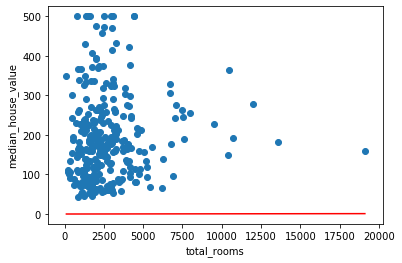

In [29]:
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

plt.scatter(sample["total_rooms"], sample["median_house_value"])
plt.show()

In [39]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = dataframe[my_label]

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]

    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)

    # Create a linear regressor object.
    my_optimizer = partial(optimizers.SGD, learning_rate=learning_rate, clipnorm=5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1) # 1행 2열 의 첫번째 plot 을 선택
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)] # linspace 는 -1 ~ 1 사이의 값을 periods 로 분할한다. 분할된 값들을 색으로 변환한다. 

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    latest_predictions = None
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period
                              )
        # Take a break and compute predictions.
        latest_predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        latest_predictions = np.array([item['predictions'][0] for item in latest_predictions])        

        # Compute loss.
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(latest_predictions, targets))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(latest_predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.10
  period 02 : 233.90
  period 03 : 232.69
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.95
  period 08 : 226.78
  period 09 : 225.62
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.62


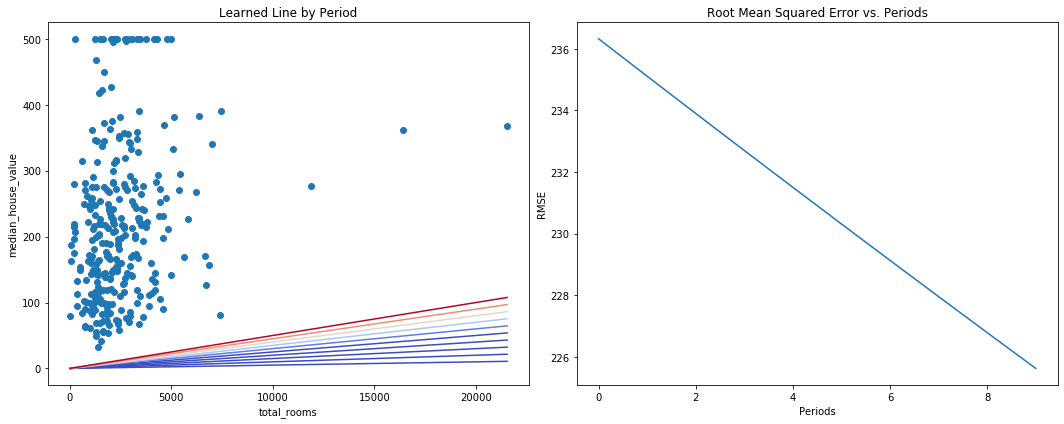

In [40]:
train_model(learning_rate=0.00001, steps=100, batch_size=1)

Training model...
RMSE (on training data):
  period 00 : 225.62
  period 01 : 214.41
  period 02 : 204.03
  period 03 : 194.96
  period 04 : 186.90
  period 05 : 180.51
  period 06 : 175.63
  period 07 : 171.21
  period 08 : 168.47
  period 09 : 167.00
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,119.0,207.3
std,98.1,116.0
min,0.1,15.0
25%,65.8,119.4
50%,95.8,180.4
75%,141.9,265.0
max,1707.2,500.0


Final RMSE (on training data): 167.00


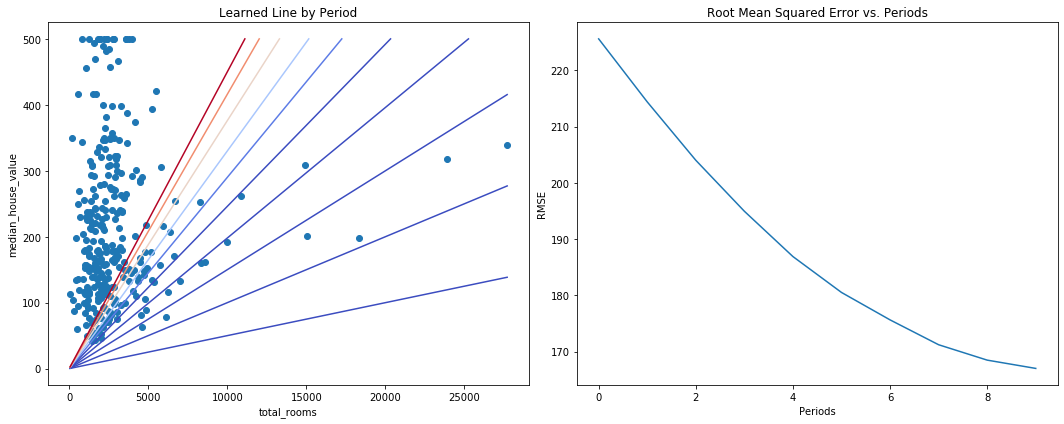

In [41]:
train_model(learning_rate=0.00002, steps=500, batch_size=5)

Training model...
RMSE (on training data):
  period 00 : 225.62
  period 01 : 214.82
  period 02 : 204.84
  period 03 : 196.23
  period 04 : 189.49
  period 05 : 184.98
  period 06 : 180.71
  period 07 : 178.32
  period 08 : 176.87
  period 09 : 176.13
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,117.0,207.3
std,93.9,116.0
min,0.3,15.0
25%,64.7,119.4
50%,95.6,180.4
75%,140.9,265.0
max,2918.9,500.0


Final RMSE (on training data): 176.13


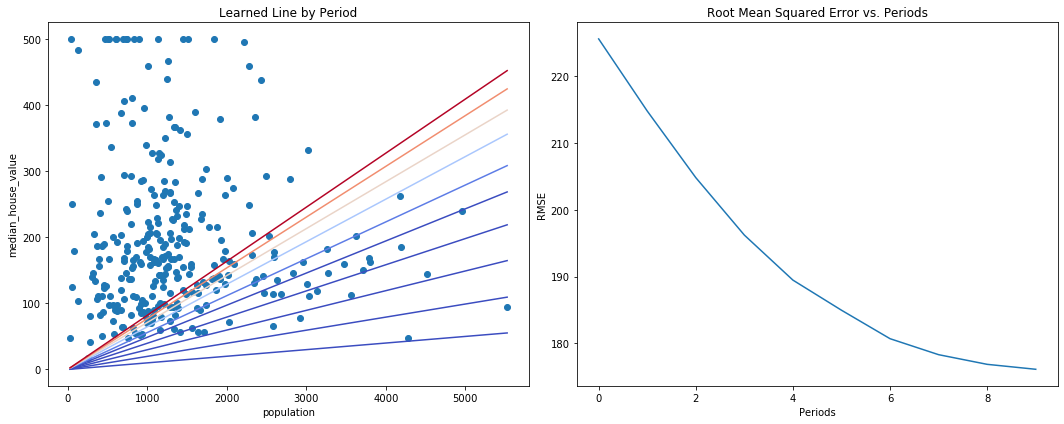

In [42]:
train_model(learning_rate=0.00002, steps=1000, batch_size=5, input_feature="population")